## Objectives:
Step two of lake_wildfire_productivity project. This isn't necessary for analysis output, rather a script to make general observations about the trends of the tabular data provided from the MTBS and the LimnoSat tabular data. Figures can be adjusted by changing parameters of the plot subset cells above plot building cells

## 1. Import needed packages and set working directory

In [1]:
import earthpy as et
import os

import folium
import ee
import geemap
import pandas as pd
import numpy as np
from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sns
import geopandas as gpd

# Check the version
print(pd.__version__)
print(gpd.__version__)

# Initialize Google Earth Engine to grab landsat images in section 4
#ee.Authenticate()
ee.Initialize()

1.2.3
0.9.0


In [2]:
# Set working directory

# if the desired path exists:
data_dir = os.path.join(et.io.HOME, 'Dropbox',
                        'CU Earth DATA Certificate 2021', 'earthlab_project')
if os.path.exists(data_dir):
    # set working directory:
    os.chdir(data_dir)
    print("path exists")
else:
    print("path does not exist, making new path")
    os.makedirs(data_dir)
    os.chdir(data_dir)

path exists


## 2. Import in tabular dataset 
Produced in the last step of 01_download_clip_merge, the merged dataset matches tabular data from MTBS and LimnoSat datasets based on overlappling lake and fire polygons

In [3]:
# Indicate path to site directories
path = os.path.join("data", "lake_mtbs_merged_tab.csv")
colo_tabular = pd.read_csv(path)

/Users/laurenkremer/miniconda3/envs/earth-analytics-python/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3165: DtypeWarning: Columns (2,22) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


## 3. Add classifications 
to the dataframe based on Landsat image date and fire ignition date

Identify Landsat imagery as pre- or post fire and add classification to new column

In [4]:
# Check date structure of ignition date (Ig_Date) and image date (date)
# colo_tabular.info()

# Both are objects after import, convert to dates
colo_tabular['date'] = pd.to_datetime(colo_tabular['date'])
colo_tabular['Ig_Date'] = pd.to_datetime(colo_tabular['Ig_Date'])
colo_tabular.Ig_Date

0       2012-06-23
1       2012-06-23
2       2012-06-23
3       2012-06-23
4       2012-06-23
           ...    
33535   2018-07-19
33536   2018-07-19
33537   2018-07-19
33538   2018-07-19
33539   2018-07-19
Name: Ig_Date, Length: 33540, dtype: datetime64[ns]

In [5]:
# Generate pre or post fire classification of Landsat imagery based on condition
# that image date is before ingition date
colo_tabular['pre_post'] = np.where(
    colo_tabular['date'] < colo_tabular['Ig_Date'], "pre-fire", "post-fire")
# print(colo_tabular.pre_post)

# Generate a calculation for the lapse of time pre- or post fire for plotting
colo_tabular['days_since'] = (colo_tabular['date'] - colo_tabular['Ig_Date'])

# Convert days_since to numerical/integer value that can be plotted
colo_tabular.days_since = colo_tabular.days_since.astype(
    'timedelta64[D]').astype(int)
# print(colo_tabular.days_since)

# Add a image month column for trend monitoring
colo_tabular['img_month'] = pd.DatetimeIndex(colo_tabular['date']).month

# Add a classification that identifies the number of years since the fire.
# This method allows for manual adjustment of year assingment
col = colo_tabular['days_since']
conditions = [(col < 2920) & (col >= 2555),
              (col < 2555) & (col >= 2190),
              (col < 2190) & (col >= 1825),
              (col < 1825) & (col >= 1460),
              (col < 1460) & (col >= 1095),
              (col < 1095) & (col >= 730),
              (col < 730) & (col >= 365),
              (col >= 0) & (col < 365),
              (col < 0) & (col >= -365),
              (col < -365) & (col >= -730),
              (col < -703) & (col >= -1095),
              (col < -1095) & (col >= -1460),
              (col < -1460) & (col >= -1825),
              (col < -1825) | (col >= -2190),
              (col < -2190) | (col >= -2555),
              (col < -2555) | (col >= -2920)]
choices = ['8', '7', '6', '5', '4', '3', '2', '1',
           '0', '-1', '-2', '-3', '-4', '-5', '-6', '-7']
colo_tabular['years_since'] = np.select(conditions, choices, default='meh')
colo_tabular['years_since'] = colo_tabular['years_since'].astype(int)

## 4. Visualize the area of color estimation 
LimnoSat provides the median band values of only high confidence water pixels within 120 meters of the
deepest point.
What does this really look like?
Here we use the deep point of Seaman Reservior in Northern Colorado to approximate where the color values 
are derived from:

In [6]:
latitude = 40.706961
longitude = -105.235506

# Make lat. and long. vars an `ee.Geometry.Point`.
point = ee.Geometry.Point([longitude, latitude])

# Apply the buffer method to the Point object.
pointBuffer = point.buffer(120);

# Apply the buffer method to the Point object.
catchmentBuffer = point.buffer(2000);

# Load a Landsat image.
img = ee.Image('LANDSAT/LC08/C01/T1_SR/LC08_034032_20180814')

Map = geemap.Map(center=[latitude,longitude], zoom=14)
Map.addLayer(img, {'bands': ['B4', 'B3', 'B2'], 'min': 200, 'max': 400}, 'example_img_seaman_res')
Map.addLayer(point, {}, 'chebysev point')
Map.addLayer(pointBuffer, {}, 'LimnoSat color derivation buffer')
Map.addLayer(catchmentBuffer, {}, 'catchment buffer')
Map

Map(center=[40.706961, -105.235506], controls=(WidgetControl(options=['position'], widget=HBox(children=(Toggl…

Whew! That was close one.  The outer buffer represents the catchment for which fire and landscape will be characterized, the inner buffer is used for color derivation. Let's look at a smaller lake, like Lake George

In [7]:
latitude = 38.984129
longitude = -105.366189

# Make lat. and long. vars an `ee.Geometry.Point`.
point = ee.Geometry.Point([longitude, latitude])

# Apply the buffer method to the Point object.
pointBuffer = point.buffer(120);

# Apply the buffer method to the Point object.
catchmentBuffer = point.buffer(2000);

# Load a Landsat image.
img = ee.Image('LANDSAT/LC08/C01/T1_SR/LC08_033033_20180823')

Map = geemap.Map(center=[latitude,longitude], zoom=14)
Map.addLayer(img, {'bands': ['B4', 'B3', 'B2'], 'min': 200, 'max': 400}, 'example_img_seaman_res')
Map.addLayer(point, {}, 'chebysev point')
Map.addLayer(pointBuffer, {}, 'LimnoSat color derivation buffer')
Map.addLayer(catchmentBuffer, {}, 'catchment buffer')
Map

Map(center=[38.984129, -105.366189], controls=(WidgetControl(options=['position'], widget=HBox(children=(Toggl…

So we definitely have some land included in these color estimates when the lakes are small. 

## 5. Plots

In [8]:
# When exploring data, can subset by month to limit seasonal effects
plot_subset = colo_tabular.loc[colo_tabular['img_month'] == 7]

plot_subset = plot_subset.loc[(plot_subset['days_since'] < 2920) & (plot_subset['days_since'] > -2920)]

#plot_subset.dtypes

Let's plot the Landsat band values in response to days since fire

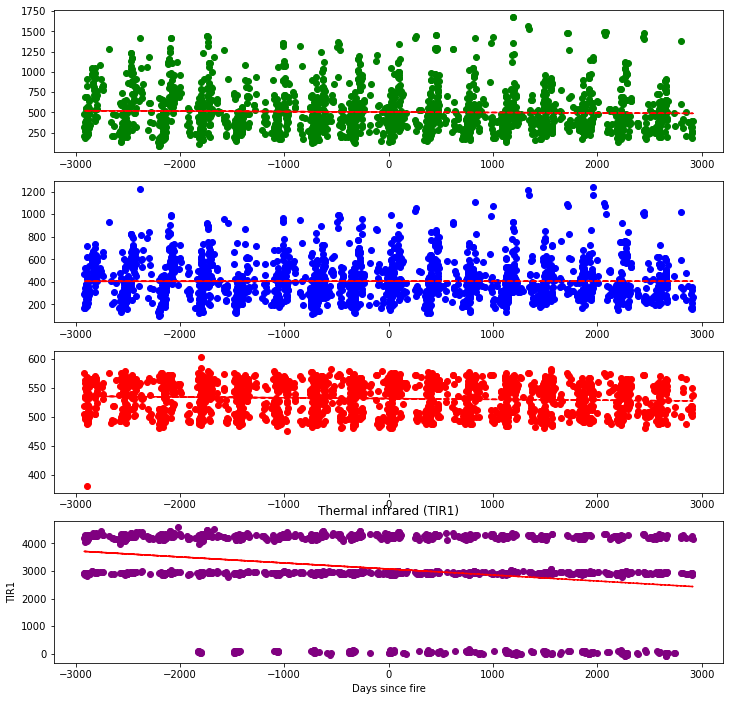

In [9]:
# Plots
# Plot 1
fig, (ax1, ax2, ax3, ax4) = plt.subplots(4, 1, figsize=(12, 12))

ax1.scatter(x=plot_subset['days_since'],
            y=plot_subset['Green'],
            color='green')

# calc the trendline
z = np.polyfit(plot_subset['days_since'], plot_subset['Green'], 1)
p = np.poly1d(z)
ax1.plot(plot_subset['days_since'], p(plot_subset['days_since']), "r--")

# Plot 2
ax2.scatter(x=plot_subset['days_since'],
            y=plot_subset['Blue'],
            color='blue')
# calc the trendline
z = np.polyfit(plot_subset['days_since'], plot_subset['Blue'], 1)
p = np.poly1d(z)
ax2.plot(plot_subset['days_since'], p(plot_subset['days_since']), "r--")

# Plot 3
ax3.scatter(x=plot_subset['days_since'],
            y=plot_subset['dWL'],
            color='red')
# calc the trendline
z = np.polyfit(plot_subset['days_since'], plot_subset['dWL'], 1)
p = np.poly1d(z)
ax3.plot(plot_subset['days_since'], p(plot_subset['days_since']), "r--")

# Plot 4
ax4.scatter(x=plot_subset['days_since'],
            y=plot_subset['TIR1'],
            color='purple')
ax4.set(title="Thermal infrared (TIR1)",
        xlabel="Days since fire",
        ylabel="TIR1")
# calc the trendline
z = np.polyfit(plot_subset['days_since'], plot_subset['TIR1'], 1)
p = np.poly1d(z)
ax4.plot(plot_subset['days_since'], p(plot_subset['days_since']), "r--")

### Estimation of Lake Color
The dWL column in the LandSat dataset provides a calculated dominant wavelength that is used to assign Forel Ule index values.
Topp's quatification of "lake color as the dominant wavelenth within the human visible spectrum by transformaing surface reflectance into the chromaticity colorspace (Wang et al. 2015). Tristimulus values were calculated from surface reflectance values":
X = 2.7689(red) + 1.7517(green) + 1.11302(blue)
Y = 1(red) + 4.5907(green) + 0.0601(blue)
Z = 0.0565(green) + 5.5943(blue)

x = X/X+Y+Z   y = Y/X+Y+Z    z = Z/X+Y+Z

Using these coordinates, the hue angle is calculated with (arctan2(x-0.33/y-0.33)(180/pi)
This is converted to dominant wavelength from (dWL)

This can be transformed to the FUI index (check out Limnosat tutorial for more): https://github.com/SimonTopp/Walkthroughs/blob/main/LimnoSat_US_Tutorial.Rmd)

In [10]:
# add forel ule index to dWL for visualization
col = colo_tabular['dWL']
conditions = [(col == 583) & (col > 581),
              (col <= 581) & (col > 579),
              (col <= 579) & (col > 577),
              (col <= 577) & (col > 575),
              (col <= 575) & (col > 573),
              (col <= 573) & (col > 571),
              (col <= 571) & (col > 570),
              (col <= 570) & (col > 569),
              (col <= 569) & (col > 568),
              (col <= 568) & (col > 567),
              (col <= 567) & (col > 564),
              (col <= 564) & (col > 559),
              (col <= 559) & (col > 549),
              (col <= 549) & (col > 530),
              (col <= 530) & (col > 509),
              (col <= 509) & (col > 495),
              (col <= 495) & (col > 489),
              (col <= 489) & (col > 485),
              (col <= 485) & (col > 480),
              (col <= 480) & (col > 475),
              (col > 470) & (col <= 475)]


choices = ['21', '20', '19', '18', '17', '16', '15', '14', '13', '12', '11',
           '10', '9', '8', '7', '6', '5', '4', '3', '2', '1']
colo_tabular['fui'] = np.select(conditions, choices, default='1001')
colo_tabular['fui'] = pd.to_numeric(colo_tabular['fui'], errors='coerce')

choices = ['a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k',
           'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u']
colo_tabular['fui_color'] = np.select(conditions, choices, default='v')

# Check that new or converted values make sense
colo_tabular[['Ig_Date', 'date', 'pre_post',
              'days_since', 'img_month', 'years_since', 'dWL', 'fui']].head

# colo_tabular.dtypes

<bound method NDFrame.head of          Ig_Date       date   pre_post  days_since  img_month  years_since  \
0     2012-06-23 1999-07-26   pre-fire       -4716          7           -5   
1     2012-06-23 1999-08-11   pre-fire       -4700          8           -5   
2     2012-06-23 1999-08-27   pre-fire       -4684          8           -5   
3     2012-06-23 1999-10-14   pre-fire       -4636         10           -5   
4     2012-06-23 1999-10-30   pre-fire       -4620         10           -5   
...          ...        ...        ...         ...        ...          ...   
33535 2018-07-19 2018-06-02   pre-fire         -47          6            0   
33536 2018-07-19 2018-06-18   pre-fire         -31          6            0   
33537 2018-07-19 2019-06-05  post-fire         321          6            1   
33538 2018-07-19 2019-07-23  post-fire         369          7            2   
33539 2018-07-19 2020-05-22  post-fire         673          5            2   

         dWL  fui  
0      496.0 

In [11]:
# Create a dictionary where you assign each attribute value to a particular color for plotting
fui_colors = {'a':  "#2158bc", 'b': "#316dc5", 'c': "#327cbb", 'd': "#4b80a0", 'e': "#568f96", 'f': "#6d9298",
              'g': "#698c86", 'h': "#759e72", 'i': "#7ba654", 'j': "#7dae38", 'k': "#94b660",
              'l': "#94b660", 'm': "#a5bc76", 'n': "#aab86d", 'o': "#adb55f", 'p': "#a8a965",
              'q': "#ae9f5c", 'r': "#b3a053", 's': "#af8a44", 't': "#a46905", 'u': "#9f4d04", 'v': "#9E250C"}

In [12]:
# Summer observations over timem (where time is relative to fire ignition date)

plot_subset = colo_tabular.loc[(colo_tabular['img_month'] == 7)
                               | (colo_tabular['img_month'] == 8)]

plot_subset = plot_subset.loc[(plot_subset['years_since'] < 8) & (
    plot_subset['years_since'] > -5) & (plot_subset['fui'] != 1001)]

# The years represented in plots may not be evident, add min and max years to plot titles
# CAN ADD THIS TO PLOT TITLE FUNCTION TO PRINT AUTOMATICALLY
max_yr = plot_subset['date'].max()
min_yr = plot_subset['date'].min()
max_lapse = plot_subset['years_since'].max()
print(max_yr)
print(min_yr)
print(max_lapse)

# plot_subset.dtypes

2019-08-26 00:00:00
1991-07-01 00:00:00
7


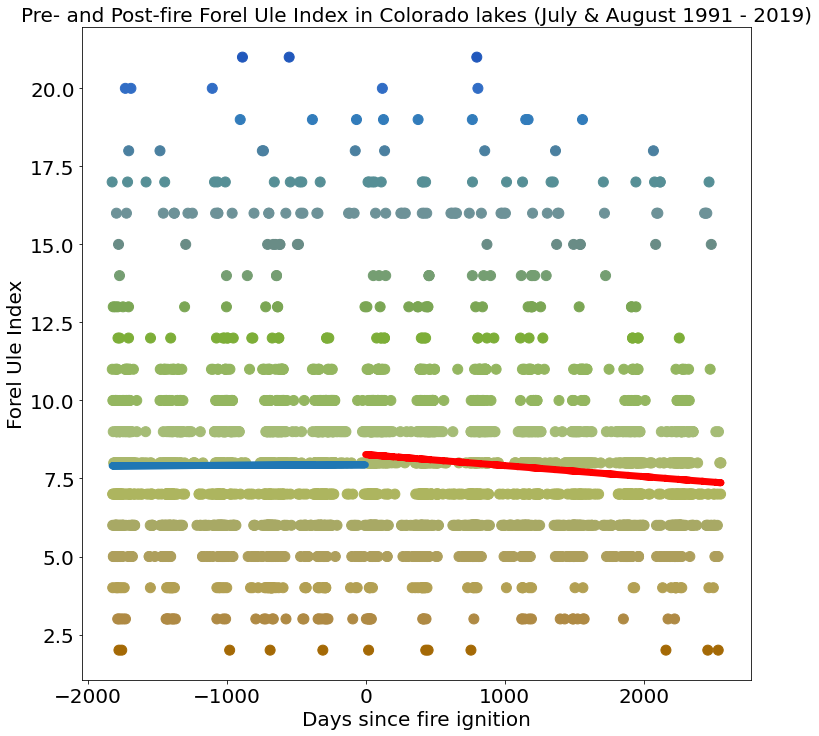

In [13]:
# plot fui trends:
# Plots

fig, (ax) = plt.subplots(figsize=(12, 12))

ax.scatter(x=plot_subset['days_since'],
           y=plot_subset['fui'],
           c=plot_subset['fui_color'].apply(lambda x: fui_colors[x]),
           s=100)


# calc the trendlines
pre_fire = plot_subset.loc[(plot_subset['days_since'] < 0)]
post_fire = plot_subset.loc[(plot_subset['days_since'] >= 0)]

z = np.polyfit(pre_fire['days_since'], pre_fire['fui'], 1)
p = np.poly1d(z)
ax.plot(pre_fire['days_since'], p(pre_fire['days_since']), linewidth=7.0)

z = np.polyfit(post_fire['days_since'], post_fire['fui'], 1)
p = np.poly1d(z)
ax.plot(post_fire['days_since'], p(
    post_fire['days_since']), "r--", linewidth=7.0)

ax.set(title='Pre- and Post-fire Forel Ule Index in Colorado lakes (July & August 1991 - 2019)',
       xlabel='Days since fire ignition',
       ylabel='Forel Ule Index')

ax.yaxis.label.set_fontsize(20)
ax.xaxis.label.set_fontsize(20)
ax.title.set_fontsize(20)
ax.tick_params(axis="x", labelsize=20)
ax.tick_params(axis="y", labelsize=20)

### Distribution by month or season
in response to years since fire

<AxesSubplot:xlabel='years_since', ylabel='fui'>

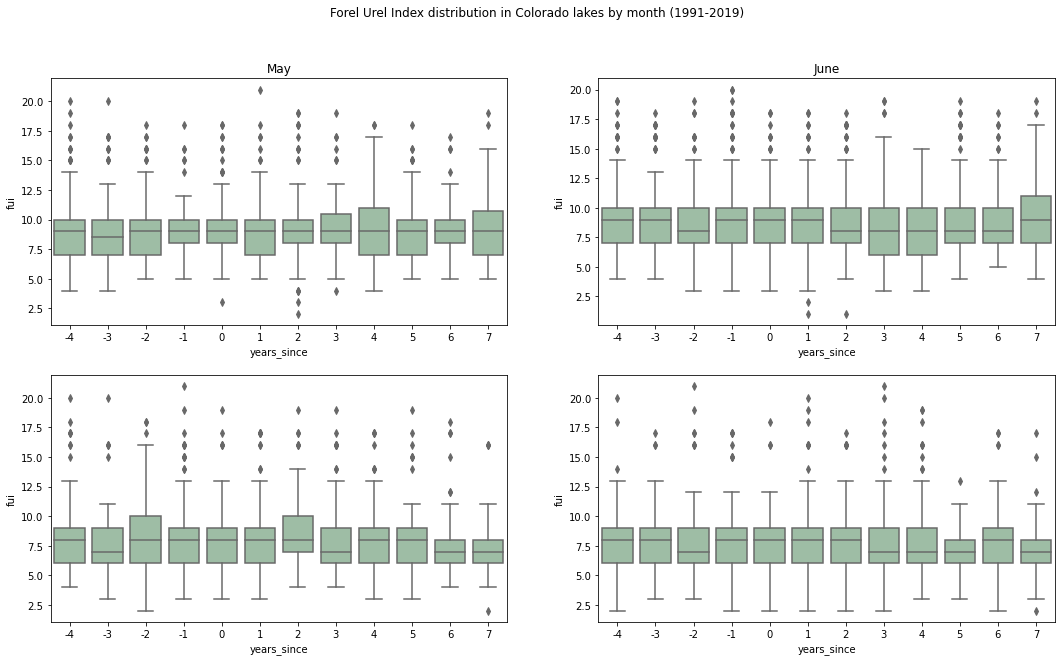

In [14]:
plot_subset = colo_tabular.loc[(colo_tabular['years_since'] < 8) & (
    colo_tabular['years_since'] > -5) & (colo_tabular['fui'] != 1001)]

# subset by month
may = plot_subset.loc[(plot_subset['img_month'] == 5)]
june = plot_subset.loc[(plot_subset['img_month'] == 6)]
july = plot_subset.loc[(plot_subset['img_month'] == 7)]
aug = plot_subset.loc[(plot_subset['img_month'] == 8)]

fig, axes = plt.subplots(2, 2, figsize=(18, 10))

fig.suptitle(
    'Forel Urel Index distribution in Colorado lakes by month (1991-2019)')

sns.boxplot(ax=axes[0, 0], data=may, x='years_since', y='fui', color='#99c2a2')
axes[0, 0].set_title("May")
# sns.swarmplot(ax=axes[0, 0], data=may, x='years_since', y='fui',color='#7d0013' )
sns.boxplot(ax=axes[0, 1], data=june,
            x='years_since', y='fui', color='#99c2a2')
axes[0, 1].set_title("June")
sns.boxplot(ax=axes[1, 0], data=july,
            x='years_since', y='fui', color='#99c2a2')

sns.boxplot(ax=axes[1, 1], data=aug, x='years_since', y='fui', color='#99c2a2')

### Trends and image color distributions of individual lakes
Boxplots

# Add a function to reduce the lines needed to adjust labeling

<ipython-input-15-0fc93d827558>:28: MatplotlibDeprecationWarning: Passing the minor parameter of set_ticks() positionally is deprecated since Matplotlib 3.2; the parameter will become keyword-only two minor releases later.
  axes[0, 0].set_xticks([], [])
<ipython-input-15-0fc93d827558>:44: MatplotlibDeprecationWarning: Passing the minor parameter of set_ticks() positionally is deprecated since Matplotlib 3.2; the parameter will become keyword-only two minor releases later.
  axes[0, 1].set_yticks([], [])
<ipython-input-15-0fc93d827558>:46: MatplotlibDeprecationWarning: Passing the minor parameter of set_ticks() positionally is deprecated since Matplotlib 3.2; the parameter will become keyword-only two minor releases later.
  axes[0, 1].set_xticks([], [])
<ipython-input-15-0fc93d827558>:72: MatplotlibDeprecationWarning: Passing the minor parameter of set_ticks() positionally is deprecated since Matplotlib 3.2; the parameter will become keyword-only two minor releases later.
  axes[1, 1]

Text(0.5, 0, 'Years since fire ignition')

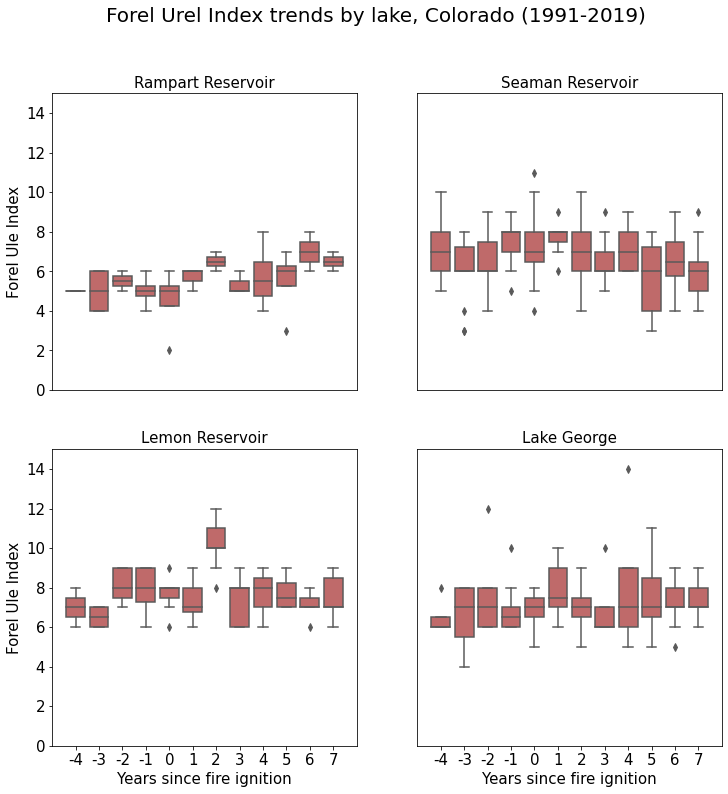

In [15]:
plot_subset = colo_tabular.loc[(colo_tabular['years_since'] < 8) & (
    colo_tabular['years_since'] > -5) & (colo_tabular['fui'] != 1001)]
plot_subset = plot_subset.loc[(colo_tabular['img_month'] == 7)
                              | (colo_tabular['img_month'] == 8)]


# subset by month
waldo = plot_subset.loc[(plot_subset['Hylak_id'] == 112400)]
seaman = plot_subset.loc[(plot_subset['Hylak_id'] == 1055287)]
george = plot_subset.loc[(plot_subset['Hylak_id'] == 1057228)]
missionary = plot_subset.loc[(plot_subset['Hylak_id'] == 112664)]
spring = plot_subset.loc[(plot_subset['Hylak_id'] == 1056666)]
forbes = plot_subset.loc[(plot_subset['Hylak_id'] == 1058951)]
wrights = plot_subset.loc[(plot_subset['Hylak_id'] == 1057446)]
silver = plot_subset.loc[(plot_subset['Hylak_id'] == 1055734)]
wrights = plot_subset.loc[(plot_subset['Hylak_id'] == 1057446)]

fig, axes = plt.subplots(2, 2, figsize=(12, 12))

fig.suptitle(
    'Forel Urel Index trends by lake, Colorado (1991-2019)', fontsize=20)

sns.boxplot(ax=axes[0, 0], data=waldo,
            x='years_since', y='fui', color='#CD5C5C')
axes[0, 0].set_title("Rampart Reservoir")
axes[0, 0].set_xlim([-1, 12])
axes[0, 0].set_ylim([0, 15])
axes[0, 0].set_xticks([], [])
axes[0, 0].set_xlabel('')
axes[0, 0].yaxis.label.set_fontsize(15)
axes[0, 0].xaxis.label.set_fontsize(15)
axes[0, 0].title.set_fontsize(15)
axes[0, 0].tick_params(axis="x", labelsize=15)
axes[0, 0].tick_params(axis="y", labelsize=15)
axes[0, 0].set_ylabel('Forel Ule Index')
# sns.swarmplot(ax=axes[0, 0], data=waldo, x='years_since', y='fui',color='#7d0013' )


sns.boxplot(ax=axes[0, 1], data=seaman,
            x='years_since', y='fui', color='#CD5C5C')
axes[0, 1].set_title("Seaman Reservoir")
axes[0, 1].set_xlim([-1, 12])
axes[0, 1].set_ylim([0, 15])
axes[0, 1].set_yticks([], [])
axes[0, 1].set_ylabel('')
axes[0, 1].set_xticks([], [])
axes[0, 1].set_xlabel('')
axes[0, 1].yaxis.label.set_fontsize(15)
axes[0, 1].xaxis.label.set_fontsize(15)
axes[0, 1].title.set_fontsize(15)
axes[0, 1].tick_params(axis="x", labelsize=15)
axes[0, 1].tick_params(axis="y", labelsize=15)

sns.boxplot(ax=axes[1, 0], data=missionary,
            x='years_since', y='fui', color='#CD5C5C')
axes[1, 0].set_title("Lemon Reservoir")
axes[1, 0].set_xlim([-1, 12])
axes[1, 0].set_ylim([0, 15])
axes[1, 0].yaxis.label.set_fontsize(15)
axes[1, 0].xaxis.label.set_fontsize(15)
axes[1, 0].title.set_fontsize(15)
axes[1, 0].tick_params(axis="x", labelsize=15)
axes[1, 0].tick_params(axis="y", labelsize=15)
axes[1, 0].set_xlabel('Years since fire ignition')
axes[1, 0].set_ylabel('Forel Ule Index')

sns.boxplot(ax=axes[1, 1], data=george,
            x='years_since', y='fui', color='#CD5C5C')
axes[1, 1].set_title("Lake George")
axes[1, 1].set_xlim([-1, 12])
axes[1, 1].set_ylim([0, 15])
axes[1, 1].set_yticks([], [])
axes[1, 1].set_ylabel('')
axes[1, 1].yaxis.label.set_fontsize(15)
axes[1, 1].xaxis.label.set_fontsize(15)
axes[1, 1].title.set_fontsize(15)
axes[1, 1].tick_params(axis="x", labelsize=15)
axes[1, 1].tick_params(axis="y", labelsize=15)
axes[1, 1].set_xlabel('Years since fire ignition')

/Users/laurenkremer/miniconda3/envs/earth-analytics-python/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='days_since', ylabel='fui'>

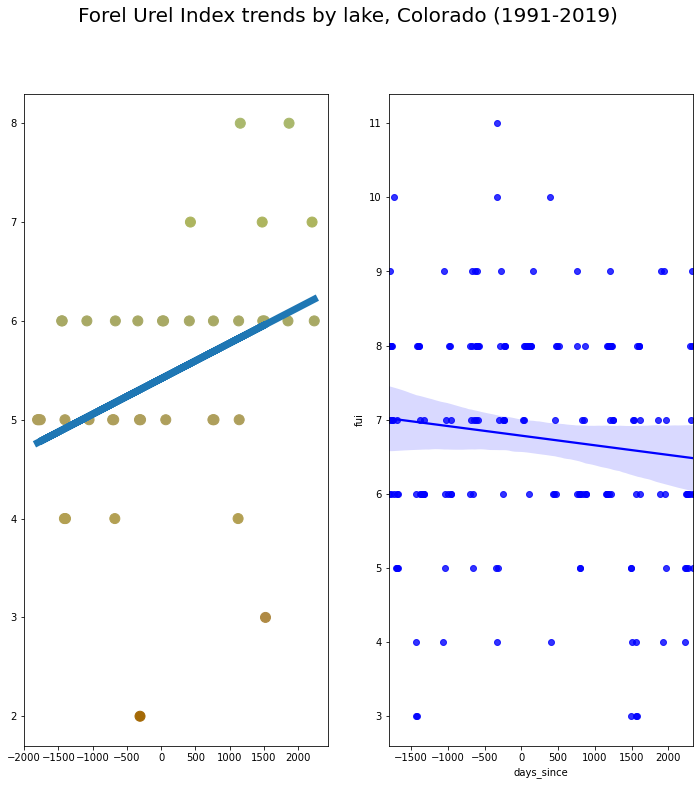

In [16]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 12))

fig.suptitle(
    'Forel Urel Index trends by lake, Colorado (1991-2019)', fontsize=20)

# Plot 1
# subset
site_plot = waldo
ax1.scatter(x=site_plot['days_since'],
            y=site_plot['fui'],
            c=site_plot['fui_color'].apply(lambda x: fui_colors[x]),
            s=100)

# calc the trendlines
pre_fire = site_plot.loc[(site_plot['days_since'] < 0)]
post_fire = site_plot.loc[(site_plot['days_since'] >= 0)]

z = np.polyfit(site_plot['days_since'], site_plot['fui'], 1)
p = np.poly1d(z)
ax1.plot(site_plot['days_since'], p(site_plot['days_since']), linewidth=7.0)

# Plot 2  # without color catagorization
site_plot = seaman
sns.regplot(site_plot['days_since'],y=site_plot['fui'], color ='blue')
